In [2]:
import urllib2
import sqlite3
import numpy as np
import pandas as pd
from sys import stdout
from datetime import datetime
import json

# Step 1: Select tweets sent from Foursquare app

In [8]:
#Step 1: Select tweets sent from Foursquare app
foursquaredata = 0
useWholeDB = True
if useWholeDB:
    con = sqlite3.connect('data/tweets/allSpringTweets.db')
    foursquaredata = pd.read_sql("SELECT * from tweets WHERE source = 'Foursquare'", con)
else:
    con = sqlite3.connect('data/foursquareSpring.db')
    foursquaredata = pd.read_sql("SELECT * from tweets", con)

In [9]:
print 'Total tweets from 4sq:', len(foursquaredata)

Total tweets from 4sq: 92387


# Step 2: Extract scipt data that contains JSON from link in the tweets

In [3]:
from bs4 import BeautifulSoup
def extract_urls(lst):
        urls = []
        for j in lst.split(' '):
            if j.startswith('http'):
                urls.append(j)
        return urls

def resolve_url(starturl):
    try:
        req = urllib2.Request(starturl)
        res = urllib2.urlopen(req, timeout = 2)
        finalurl = res.geturl()
        soup = BeautifulSoup(res.read())
        #print soup.find_all('script')
        #print(soup.prettify())
        
        return soup
    except:
        pass
    
def progress(i, n):
    stdout.write("\r%f%%" % (i*100/float(n)))
    stdout.flush()
    if i == n-1:
        stdout.write("\r100%")
        print("\r\n")

In [ ]:
#Step 2: Extract scipt data that contains JSON from link in the tweets
batchSize = len(foursquaredata)/10
for iteration in range(1,11):
    print iteration
    print '\n'
    htmls = []
    for index, row in foursquaredata[iteration*batchSize:(iteration+1)*batchSize].iterrows():
        lst = row.content
        urls = extract_urls(lst)
        #Get the url content
        if len(urls):
            htmls.append(resolve_url(urls[0]))
        progress(index-iteration*batchSize,batchSize)
    
    #Get the string with javascript and it's JSON
    scripts = []
    for html in htmls:
        if (html is not None):
            if len(html.find_all('script'))>10:
                scripts.append([str(html.find_all('script')[10])])
            else:
                scripts.append([])
        else:
            scripts.append([])
     
    with open('data/script'+str(iteration+1)+'.p', 'wb') as fileToSave:
        np.save(fileToSave, scripts)

In [ ]:
#You can load all the saved scripts
with open('data/allScripts.p') as fileWithScripts:
    theScripts = np.load(fileWithScripts)

In [89]:
totalExtracted = 0
for scriptArray in theScripts:
    if len(scriptArray):
        totalExtracted = totalExtracted + 1
print 'Total scripts from 4sq:', totalExtracted

Total scripts from 4sq: 87253


In [6]:
#Join all the scripts 
for iteration in range(1,9):
    with open('data/script'+str(iteration)+'.p', 'r') as fileToSave:
        theScripts = np.append(theScripts, np.load(fileToSave))

# Step 3: Get JSON out of scripts string

In [12]:
#Step 3: Get JSON out of scripts string
checkinStopWord = 'checkin: '
venueStopWord = ',venue: ' 
failed = 0
parsedCheckins = []
for scriptArray in theScripts:
    if len(scriptArray):
        scriptString = scriptArray[0]
        checkInJSON = scriptString[scriptString.find(checkinStopWord)+len(checkinStopWord):scriptString.find(venueStopWord)]
        try:
            parsedCheckins.append(json.loads(checkInJSON))
        except:
            failed = failed + 1
print 'Failed to parse:', failed

204


# Step 4: Save it all to big JSON array

In [10]:
with open('data/tweets/checkins.json', 'w') as outfile:
    json.dump(parsedCheckins, outfile)

NameError: name 'parsedCheckins' is not defined

In [11]:
with open('data/tweets/allSpringCheckins.json', 'r') as datafile:
      parsedCheckins = json.load(datafile)
print len(parsedCheckins)

87049


# Step 5: Get Data Frame out of JSON

In [20]:
#Create Categories data frame
categories = []
categoryIds = []
for checkIn in parsedCheckins:
    checkInVenue = checkIn['venue']
    for category in checkInVenue['categories']:
        
        if category['primary']:
            if category['id'] not in categoryIds:
                categories.append({'categoryId':category['id'],
                                  'name':category['name']})
                categoryIds.append(category['id'])
                
categoriesDF = pd.DataFrame(categories)

In [12]:
#Create Venues data frame
venues = []
venuesIds = []
for checkIn in parsedCheckins:
    checkInVenue = checkIn['venue']
    if checkInVenue['id'] not in venuesIds:
        venueInfo = {'venueId':checkInVenue['id'],
                    'name':checkInVenue['name'],
                    'checkinsCount':checkInVenue['stats']['checkinsCount'],
                    'tipCount':checkInVenue['stats']['tipCount'],
                    'usersCount':checkInVenue['stats']['usersCount']}
        for category in checkInVenue['categories']:
            if category['primary']:
                venueInfo["categoryId"] = category['id']
        if checkInVenue['location']:
            if 'address' in checkInVenue['location'].keys() and checkInVenue['location']['address']:
                venueInfo["address"] = checkInVenue['location']['address']
        if 'postalCode' in checkInVenue['location'].keys() and checkInVenue['location']['postalCode']:
            venueInfo["postalCode"] = checkInVenue['location']['postalCode']
        if 'neighborhood' in checkInVenue['location'].keys() and checkInVenue['location']['neighborhood']:
            venueInfo["neighborhood"] = checkInVenue['location']['neighborhood']
        if 'lat' in checkInVenue['location'].keys() and 'lng' in checkInVenue['location'].keys() and checkInVenue['location']['lat'] and checkInVenue['location']['lng']:
            venueInfo["lat"] = checkInVenue['location']['lat']
            venueInfo["lng"] = checkInVenue['location']['lng']
        venues.append(venueInfo)
        venuesIds.append(checkInVenue['id'])
                
venuesDF = pd.DataFrame(venues)

In [13]:
#Create Users data frame
users = []
userIds = []
for checkIn in parsedCheckins:
    userInVenue = checkIn['user']
    if userInVenue['id'] not in userIds:
        userInfo = {'userId':userInVenue['id'],
                    'checkinsCount':0}
        if 'gender' in userInVenue.keys() and userInVenue['gender']:
            userInfo["gender"] = userInVenue['gender']
        if 'firstName' in userInVenue.keys() and userInVenue['firstName']:
            userInfo["firstName"] = userInVenue['firstName']
        if 'lastName' in userInVenue.keys() and userInVenue['lastName']:
            userInfo["lastName"] = userInVenue['lastName']
        users.append(userInfo)
        userIds.append(userInVenue['id'])
                
usersDF = pd.DataFrame(users)

In [15]:
#Create Check-ins data frame
checkIns = []
checinIds = []
for checkIn in parsedCheckins:
    if checkIn['id'] not in checinIds:
        checkInInfo = {'checkinId':checkIn['id'],
                    'createdAt':checkIn['createdAt'],
                    'tzOffset':checkIn['timeZoneOffset'],
                    'userId':checkIn['user']['id'],
                    'venueId':checkIn['venue']['id']}
        
        if 'likes' in checkIn.keys() and checkIn['likes']:
            userInfo["likes"] = checkIn['likes']['count']
        if 'photos' in checkIn.keys() and checkIn['photos']:
            userInfo["photos"] = checkIn['photos']['count']
        checkIns.append(checkInInfo)
        checinIds.append(checkIn['id'])
                
checkinsDF = pd.DataFrame(checkIns)

In [ ]:
# A try on generic parser
def getDataFrameFromCheckinsJSON(keysMapping, optionalKeysMapping, parsedCheckins, subPath = False):
    items = []
    itemIds = []
    for checkIn in parsedCheckins:
        
        if subPath:
            itemData = checkIn[subPath]
        else:
            itemData = checkIn

        if itemData['id'] not in itemIds:
            itemInfo = {}
            
            #Add all requires values
            for keysMap in keysMapping:
                if keysMap['jsonKey'] is str:
                    itemInfo[keysMap['pandasKey']] = itemData[keysMap['jsonkey']]
                else:
                    itemInfo[keysMap['pandasKey']] = itemData[keysMap['jsonKey']['key']][keysMap['jsonKey']['subKey']]
            
            #Add all optional values
            for key in optionalKeysMapping:
                if keysMap['jsonKey'] is str:
                    if keysMap['jsonkey'] in itemData.keys():
                        itemInfo[keysMap['pandasKey']] = itemData[keysMap['jsonkey']]
                else:
                    if keysMap['jsonKey']['key'] in itemData.keys() and keysMap['jsonKey']['subKey'] in itemData[keysMap['jsonKey']['key']].keys():
                        itemInfo[keysMap['pandasKey']] = itemData[keysMap['jsonKey']['key']][keysMap['jsonKey']['subKey']]

            users.append(itemInfo)
            itemIds.append(itemData['id'])

    itemsDF = pd.DataFrame(items)

In [17]:
def extractComponents(row):
    date = datetime.utcfromtimestamp(row.createdAt+(row.tzOffset-60)*60)
    months.append(date.month)
    days.append(date.day)
    hours.append(date.hour)
    miuntes.append(date.minute)
    weekdays.append(date.weekday())
    
months = []
days = []
hours = []
miuntes = []
weekdays = []

checkinsDF.apply(extractComponents, axis=1)
checkinsDF['month'] = months
checkinsDF['day'] = days
checkinsDF['hour'] = hours
checkinsDF['minute'] = miuntes
checkinsDF['weekday'] = weekdays
#help(pytz)

# Step 6: Saving all data from JSON to SQLLite with tables: Users, Venues, Checkins, Categories

In [16]:
#Saving all data from JSON to SQLLite
checkinCon = sqlite3.connect('data/tweets/checkinsSpring.db')

In [18]:
checkinsDF.to_sql('checkins', checkinCon)

In [21]:
categoriesDF.to_sql('categories', checkinCon)

In [22]:
venuesDF.to_sql('venues', checkinCon)

In [23]:
usersDF.to_sql('users', checkinCon)

In [6]:
checkinsDF = pd.read_sql('SELECT * from checkins', checkinCon)
categoriesDF = pd.read_sql('SELECT * from categories', checkinCon)
venuesDF = pd.read_sql('SELECT * from venues', checkinCon)
usersDF = pd.read_sql('SELECT * from users', checkinCon)

DatabaseError: Execution failed on sql 'SELECT * from checkins': no such table: checkins

In [141]:
healthVenues.to_csv('data/venues.tsv', sep='\t',encoding='utf-8')
healthCheckIns.to_csv('data/checkins.tsv', sep='\t',encoding='utf-8')
healthUsers.to_csv('data/users.tsv', sep='\t',encoding='utf-8')

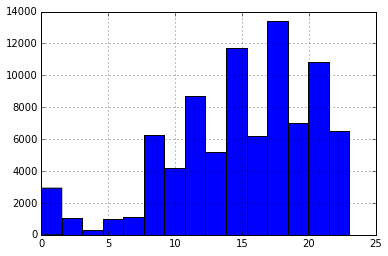

In [26]:
import matplotlib
%matplotlib inline
checkinsDF.hour.hist(bins = 15)

### Analyze!

In [14]:
with open('data/healthCategories.json') as healthCatsFile:
    healthCategories = json.load(healthCatsFile)
    healthIds = [healthCat['id'] for healthCat in healthCategories]

In [15]:
#Get all the health venues
healthVenues = venuesDF[venuesDF.categoryId.isin(healthIds)].sort('checkinsCount',ascending = False)

In [22]:
#Get correspoding check-ins
healthCheckIns = checkinsDF[checkinsDF.venueId.isin(healthVenues.venueId.tolist())]

In [19]:
len(healthUsers)

2369

In [18]:
healthUsers = usersDF[usersDF.userId.isin(healthCheckIns.userId.tolist())]

In [7]:
sortedHealthVenues = []
for venueId, group in healthCheckIns.groupby('venueId').agg('size').order(ascending = False).iteritems():
    sortedHealthVenues.append(venueId)

In [8]:
#add a specific order
healthVenues['sortedId'] = pd.Categorical(
    healthVenues['venueId'], 
    categories=sortedHealthVenues, 
    ordered=True
)

In [10]:
top50HealtIds = healthVenues.sort('sortedId', ascending=True)[:90]['venueId'].tolist()
top50HealtLats = healthVenues.sort('sortedId', ascending=True)[:90]['lat'].tolist()
top50HealtLongs = healthVenues.sort('sortedId', ascending=True)[:90]['lng'].tolist()

In [11]:
healthJson = []
for index, venueId in enumerate(top50HealtIds):
    healthJson.append({'venueId':venueId,
                      'll':str(top50HealtLats[index])+','+str(top50HealtLongs[index])})
with open('data/top90healthVenuesSummer.json', 'w') as outfile:
    json.dump(healthJson, outfile)

In [12]:
healthVenues.sort('sortedId', ascending=True)[:90].to_csv('data/topHealthVenues90.tsv', sep='\t',encoding='utf-8')

In [150]:
with open('data/top50healthPlacesSpring.json', 'w') as outfile:
    json.dump(top50HealtPlaces, outfile)

In [151]:
healthVenues.sort('sortedId')[:30]

,address,categoryId,checkinsCount,lat,lng,name,neighborhood,postalCode,tipCount,usersCount,venueId,sortedId
1687,"ул. Крымский Вал, 9",4bf58dd8d48988d163941735,402360,55.728125,37.601223,ЦПКиО им. Горького / Gorky Park,Парк Горького,119049,1419,113166,4bdd5f27f219c9b6bb751210,4bdd5f27f219c9b6bb751210
110,"просп. Мира, 119",4bf58dd8d48988d163941735,105461,55.829830,37.631800,ВДНХ (Выставка достижений народного хозяйства),Останкинский,129223,504,49650,4e4aab0f62e13240b700e034,4e4aab0f62e13240b700e034
1666,Крымская наб.,4bf58dd8d48988d163941735,51045,55.735181,37.607789,Парк искусств «Музеон» / Muzeon Park,Якиманка,119049,366,28295,4bc090ca920eb7132e14192c,4bc090ca920eb7132e14192c
266,"ул. Сокольнический Вал, 1, стр. 1",4bf58dd8d48988d163941735,100019,55.794719,37.676561,ПКиО «Сокольники»,Сокольники,107113,686,45437,4bc8760792b376b03767513a,4bc8760792b376b03767513a
2034,"Олимпийский просп., 16",4bf58dd8d48988d184941735,44706,55.781026,37.626436,СК «Олимпийский»,Мещанский,129090,238,26782,4b9bb751f964a520361d36e3,4b9bb751f964a520361d36e3
1640,Малая Бронная ул.,4bf58dd8d48988d163941735,74870,55.763887,37.592082,Патриаршие пруды / Patriarshiye Ponds,Патриаршие пруды,NaN,314,33821,4bb41c28f187a593f1e913f8,4bb41c28f187a593f1e913f8
1738,Кутузовский просп.,4bf58dd8d48988d163941735,61913,55.731677,37.506981,Парк Победы (Поклонная гора) / Victory Park,Дорогомилово,NaN,218,31856,4bdc9716afe8c9b689235085,4bdc9716afe8c9b689235085
560,NaN,4bf58dd8d48988d163941735,53498,55.661272,37.664051,Музей-заповедник «Коломенское»,NaN,115487,372,28365,4b827a36f964a52098d430e3,4b827a36f964a52098d430e3
2683,"ТРЦ ""Филион""",4bf58dd8d48988d175941735,14363,55.744273,37.509048,ALEX-Fitness,Филёвский парк,NaN,83,1291,4cee97333b03f04da5ba3adc,4cee97333b03f04da5ba3adc
319,"Дольская ул., 1",4bf58dd8d48988d163941735,47773,55.615880,37.682161,Музей-заповедник «Царицыно»,Бирюлёво Восточное,115569,410,28329,4c11f318d5599521185818b9,4c11f318d5599521185818b9


In [68]:
categoriesSorted = {}
for venueId, group in checkinsDF.groupby('venueId').agg('size').order(ascending = False).iteritems():
    #print venuesDF[venuesDF.venueId == venueId].iloc[0]['name'], group
    try:
        name = categoriesDF[categoriesDF.categoryId == venuesDF[venuesDF.venueId == venueId].iloc[0]['categoryId']].iloc[0]['name']
        if name in categoriesSorted.keys():
            categoriesSorted[name] = categoriesSorted[name] + group
        else:
            categoriesSorted[name] = group
    except:
        pass

In [49]:
import operator
sorted_categoriesSorted = sorted(categoriesSorted.items(), key=operator.itemgetter(1))

TypeError: bad operand type for unary -: 'operator.itemgetter'

In [62]:
len(sorted_categoriesSorted)

260

In [65]:
sum([cat[1] for cat in sorted_categoriesSorted])

50432

In [56]:
for cat in reversed(sorted_categoriesSorted[-100:]):
    print cat[0], cat[1]

Mall 4738
Home (private) 3257
Airport 2810
University 2620
Park 2588
Train Station 1990
Metro Station 1768
Office 1337
Coffee Shop 1320
Gym / Fitness Center 1319
Residential Building (Apartment / Condo) 1222
Multiplex 1086
Street 1080
Plaza 965
Neighborhood 889
City 719
Nightclub 704
School 647
Bar 642
Concert Hall 595
Bus Stop 526
Fast Food Restaurant 525
Soccer Stadium 506
Theater 499
Airport Terminal 460
Hotel 457
Gym 452
Cocktail Bar 347
Baby Store 337
Café 330
Housing Development 315
College Academic Building 312
Pub 312
Art Gallery 307
Platform 303
Restaurant 269
Event Space 264
Lake 231
Diner 230
Stadium 229
Country 221
American Restaurant 216
Government Building 208
Dance Studio 200
Big Box Store 197
Art Museum 197
Movie Theater 188
Law School 185
Building 183
College Residence Hall 180
Bridge 177
High School 177
Pedestrian Plaza 165
Middle School 162
Burger Joint 161
Furniture / Home Store 160
Other Event 160
Hospital 159
Bakery 158
Tech Startup 148
Sushi Restaurant 147
Cowork

In [44]:
for checkin in enumerate(checkinsDF):
    checkin['categoryName'] = categoriesDF[categoriesDF.categoryId == venuesDF[venuesDF.venueId == checkin.venueId].iloc[0]['categoryId']].iloc[0]['name']


AttributeError: 'tuple' object has no attribute 'venueId'

In [30]:
categoriesSorted[:50]

[u'Zoo',
 u'Dumpling Restaurant',
 u'Dessert Shop',
 u'Diner',
 u'Distillery',
 u'Distribution Center',
 u'Dive Bar',
 u'Dive Spot',
 u"Doctor's Office",
 u'Dog Run',
 u'Doner Restaurant',
 u'Donut Shop',
 u'Driving School',
 u'Drugstore / Pharmacy',
 u'Dry Cleaner',
 u'Eastern European Restaurant',
 u'Department Store',
 u'Electronics Store',
 u'Elementary School',
 u'Embassy / Consulate',
 u'Emergency Room',
 u'Ethiopian Restaurant',
 u'Event Service',
 u'Event Space',
 u'Fabric Shop',
 u'Factory',
 u'Fair',
 u'Falafel Restaurant',
 u'Farm',
 u'Farmers Market',
 u'Design Studio',
 u"Dentist's Office",
 u'Festival',
 u'Convention Center',
 u'College Theater',
 u'College Track',
 u'Comedy Club',
 u'Comfort Food Restaurant',
 u'Comic Shop',
 u'Community Center',
 u'Community College',
 u'Concert Hall',
 u'Conference',
 u'Conference Room',
 u'Construction & Landscaping',
 u'Convenience Store',
 u'Convention',
 u'Corporate Cafeteria',
 u'Deli / Bodega',
 u'Cosmetics Shop']

In [263]:
# Get the last unbroken script
scriptId = 0
scriptStep = 0
for scriptArray in theScripts:
    if len(scriptArray)>0:
        scriptId = scriptStep
    scriptStep = scriptStep+1

In [ ]:
healthCategories = [
     {'id':'4bf58dd8d48988d163941735',
 'name':'Park'},
{'id':'4bf58dd8d48988d175941735',
'name':'Gym / Fitness Center'},
{'id':'4bf58dd8d48988d176941735',
'name':'Gym'},
{'id':'4bf58dd8d48988d188941735 ',
'name':'Soccer Stadium'},
{'id':'4bf58dd8d48988d104941735',
'name':'Medical Center'},
{'id':'4bf58dd8d48988d196941735',
'name':'Hospital'},
{'id':'4bf58dd8d48988d134941735',
'name':'Dance Studio'},
{'id':'4bf58dd8d48988d184941735',
'name':'Stadium'},
{'id':'4bf58dd8d48988d178941735',
'name':'Dentist\'s Office '},
{'id':'4bf58dd8d48988d185941735',
'name':'Hockey Arena'},
{'id':'4bf58dd8d48988d105941735',
'name':'Gym Pool'},
{'id':'4bf58dd8d48988d15e941735',
'name':'Pool'},
{'id':'4f4528bc4b90abdf24c9de85',
'name':'Athletics & Sports'},
{'id':'4cce455aebf7b749d5e191f5',
'name':'Soccer Field'},
 {'id':'4bf58dd8d48988d102941735',
'name':'Yoga Studio'}]

with open('data/healthCategories.json', 'w') as outfile:
    json.dump(healthCategories, outfile)